In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
#%pip install sklearn-model 
from torchvision import transforms
#%pip install torchvision 
import torch
#%pip install torch
from torch.utils.data import Dataset, DataLoader

# Brain Tumor
Para este projeto, escolhemos o dataset de imagens de tumores cerebrais, que está disponível no Kaggle. Este dataset contém imagens de ressonância magnética de cérebros, rotuladas em diferentes categorias: glioma, meningioma, pituitária e saudável.

 
> Problema e Objetivo do Modelo:

O objetivo deste modelo de Deep Learning é classificar imagens de ressonância magnética de cérebros em diferentes categorias de tumores (glioma, meningioma, pituitária) ou identificar se a imagem é de um cérebro saudável. O modelo deve ser capaz de diferenciar entre essas classes de forma eficaz para auxiliar no diagnóstico médico.

> Classes a serem classificadas:

* Glioma: Tumor cerebral.
* Meningioma: Tumor que se forma nas membranas que envolvem o cérebro.
* Pituitária: Tumor na glândula pituitária.
* Saudável: Imagens sem sinais de tumor.

Link do Dataset: O dataset foi obtido do Kaggle: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans/

In [ ]:
# Caminhos das categorias de imagens
data_paths = {
    "glioma": "./glioma",
    "healthy": "./healthy",
    "meningioma": "./meningioma",
    "pituitary": "./pituitary"
}


In [42]:
# Número de imagens a exibir por categoria
num_images_per_class = 6


In [28]:
# Função para verificar se o diretório existe
def verificar_diretorio(path):
    """Verifica se o diretório existe e se contém imagens."""
    caminho = Path(path)
    if caminho.exists() and caminho.is_dir():
        return list(caminho.glob("*"))  # Retorna lista de arquivos na pasta
    else:
        print(f"Erro: O diretório {path} não foi encontrado.")
        return []

In [44]:
# Função para exibir as imagens
def exibir_imagens(data_paths, num_images_per_class):
    """Exibe imagens de cada categoria selecionada."""
    # Cria a figura para exibir as imagens
    plt.figure(figsize=(12, 8))
    
    # Itera sobre as categorias de imagens
    for idx, (label, path) in enumerate(data_paths.items()):
        # Obtém os arquivos de imagem da pasta
        imagens = verificar_diretorio(path)
        
        # Se não houver imagens, pula para a próxima categoria
        if not imagens:
            continue
        
        # Seleciona aleatoriamente algumas imagens
        selected_images = random.sample(imagens, min(num_images_per_class, len(imagens)))
        
        # Exibe as imagens selecionadas
        for i, img_file in enumerate(selected_images):
            img = mpimg.imread(img_file)  # Lê a imagem
            plt.subplot(len(data_paths), num_images_per_class, idx * num_images_per_class + i + 1)
            plt.imshow(img, cmap='gray')  # Exibe a imagem em escala de cinza
            plt.title(label.capitalize())  # Define o título com o nome da categoria
            plt.axis('off')  # Remove os eixos
            
    # Ajusta a disposição das imagens e exibe
    plt.tight_layout()
    plt.show()

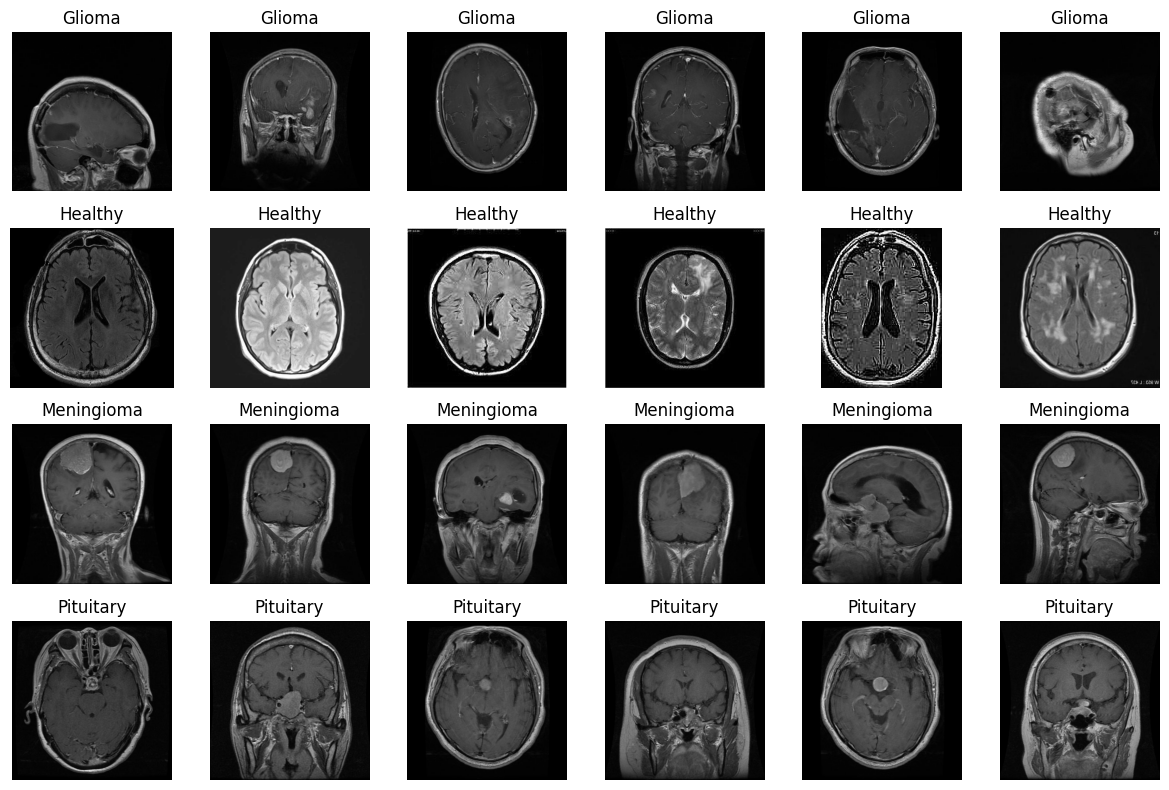

In [45]:
# Chama a função para exibir as imagens
exibir_imagens(data_paths, num_images_per_class)

In [46]:
# Definição dos tamanhos de corte e redimensionamento
crop_size = 512  # Tamanho do corte central
target_size = 256  # Tamanho alvo para redimensionamento (pode ser ajustado para 128 ou 256)
batch_size = 32


In [47]:
# Função de pré-processamento
def preprocess_image(img_path):
    """
    Função para pré-processar as imagens:
    1. Cortar as imagens para o tamanho desejado
    2. Redimensionar para o tamanho alvo
    3. Normalizar
    """
    img = Image.open(img_path)
    width, height = img.size
    
    # Recorte centralizado se a imagem for maior que o tamanho de corte
    if width > crop_size or height > crop_size:
        left = (width - crop_size) / 2
        top = (height - crop_size) / 2
        right = (width + crop_size) / 2
        bottom = (height + crop_size) / 2
        img = img.crop((left, top, right, bottom))
    
    # Redimensionamento para o tamanho alvo
    img = img.resize((target_size, target_size))

    # Aplicar normalização
    img = np.array(img) / 255.0  # Normalizando para o intervalo [0, 1]
    
    return img

In [48]:
# Classe Dataset personalizada
class BrainTumorDataset(Dataset):
    def __init__(self, data_paths, transform=None):
        self.data_paths = data_paths
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Preencher a lista de imagens e labels
        for label, path in data_paths.items():
            class_index = list(data_paths.keys()).index(label)  # Assign a unique class index
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                self.images.append(img_path)
                self.labels.append(class_index)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = preprocess_image(img_path)  # Pré-processa a imagem

        # Aplicar transformações, se existirem
        if self.transform:
            img = self.transform(img)

        return img, label

In [51]:
# Definir as transformações para o modelo
transform = transforms.Compose([
    transforms.ToTensor(),  # Converte para Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normaliza para valores entre [-1, 1]
])

In [52]:
# Criar dataset e dividir em treino, validação e teste
dataset = BrainTumorDataset(data_paths, transform=transform)

# Divisão em treino e teste (80% treino, 20% teste)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Divisão em treino e validação (80% treino, 20% validação)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

# DataLoader para carregamento dos dados
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


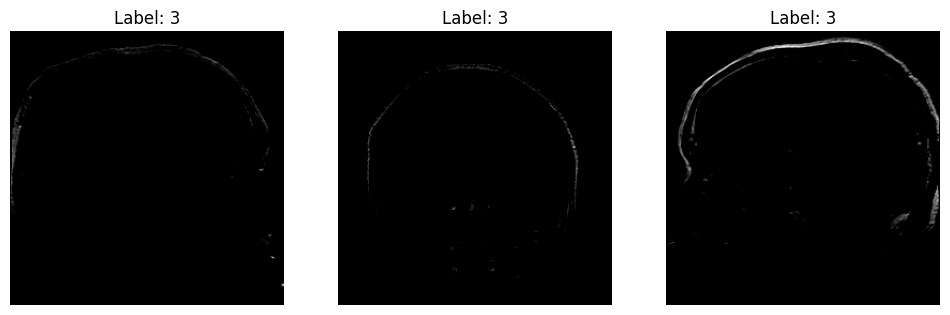

In [55]:
def show_examples(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        axes[i].imshow(images[i].permute(1, 2, 0))  # Reorganiza as dimensões do Tensor (C, H, W) para (H, W, C)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {labels[i].item()}")
    plt.show()

# Mostrar alguns exemplos de treino
show_examples(train_loader)